In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

train = spark.read.parquet("/Users/anatolijperederij/PycharmProjects/nyc-taxi-ml-pipeline/data/raw/train")
eval = spark.read.parquet("/Users/anatolijperederij/PycharmProjects/nyc-taxi-ml-pipeline/data/raw/eval")
holdout = spark.read.parquet("/Users/anatolijperederij/PycharmProjects/nyc-taxi-ml-pipeline/data/raw/holdout")



Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/11 21:00:04 WARN Utils: Your hostname, Anatolijs-MacBook-Air-2.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
26/02/11 21:00:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/11 21:00:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
train.count()

58244348

In [3]:
train_pd = train.sample(fraction= 0.001, seed = 42).toPandas()
train_pd.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

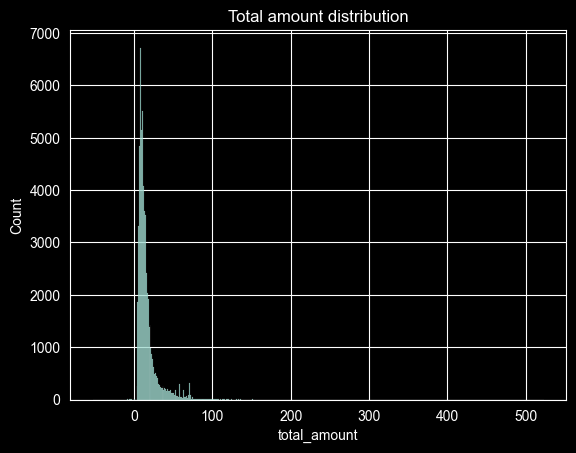

In [4]:
sns.histplot(data = train_pd, x="total_amount")
plt.title("Total amount distribution")
plt.show()

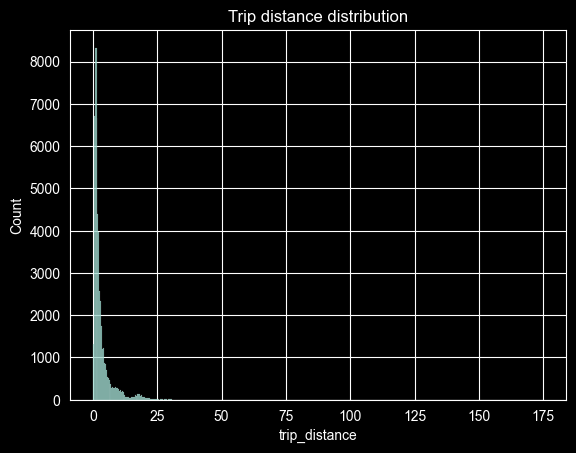

In [5]:
sns.histplot(data = train_pd, x="trip_distance")
plt.title("Trip distance distribution")
plt.show()

In [6]:
train.select(F.min("total_amount"), F.max("total_amount") , F.mean("total_amount"), F.median("total_amount")).show()

+-----------------+-----------------+------------------+--------------------+
|min(total_amount)|max(total_amount)| avg(total_amount)|median(total_amount)|
+-----------------+-----------------+------------------+--------------------+
|           -958.4|        429562.25|16.037992702344585|                11.8|
+-----------------+-----------------+------------------+--------------------+



In [7]:
train.select(F.min("trip_distance"), F.max("trip_distance") , F.mean("trip_distance"), F.median("trip_distance")).show()


+------------------+------------------+------------------+---------------------+
|min(trip_distance)|max(trip_distance)|avg(trip_distance)|median(trip_distance)|
+------------------+------------------+------------------+---------------------+
|               0.0|      1.90726288E7| 4.912094451980118|                  1.7|
+------------------+------------------+------------------+---------------------+



# price must be above `0$` and 100% below `429562$` so lets delete outliers. Distance can't be 1.90726288E7

In [8]:
def remove_outliers(df):
    df = df.filter(
        (F.col("total_amount") > 0) & (F.col("total_amount") < 500) &
        (F.col("trip_distance") > 0) & (F.col("trip_distance") < 75)
)

    return df

train = remove_outliers(train)
eval = remove_outliers(eval)
holdout = remove_outliers(holdout)

train.count()

57892523

In [9]:
train.describe(["trip_distance", "total_amount" , "fare_amount"]).show()

+-------+------------------+------------------+------------------+
|summary|     trip_distance|      total_amount|       fare_amount|
+-------+------------------+------------------+------------------+
|  count|          57892523|          57892523|          57892523|
|   mean| 2.960790989710032|15.967372265630692|12.740274634601748|
| stddev|3.6239044199940094|13.150898789060594|10.598016683044483|
|    min|              0.01|              0.01|               0.0|
|    max|             74.94|            498.57|             495.0|
+-------+------------------+------------------+------------------+



In [10]:
train = train.repartition(4)  # 4 файла вместо сотен
train.write.parquet("../data/processed/train")
eval = eval.repartition(4)  # 4 файла вместо сотен
eval.write.parquet("../data/processed/eval")
holdout = holdout.repartition(4)  # 4 файла вместо сотен
holdout.write.parquet("../data/processed/holdout")
spark.stop()

[35.966s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 19.0 (TID 88): Retried waiting for GCLocker too often allocating 16777218 words
[35.973s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 19.0 (TID 88): Retried waiting for GCLocker too often allocating 16777218 words
[35.979s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 19.0 (TID 88): Retried waiting for GCLocker too often allocating 16777218 words
[35.983s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 19.0 (TID 88): Retried waiting for GCLocker too often allocating 16777218 words


26/02/11 21:00:40 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
26/02/11 21:00:40 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
26/02/11 21:00:40 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
26/02/11 21:00:40 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
